## Step 1: Setup and Data Loading


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [ ]:
# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [ ]:
# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [ ]:
import joblib  # for saving models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import os

In [ ]:
df = pd.read_csv("diamonds.csv")  # update path

In [ ]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
df.shape

(53940, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [ ]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## Step 2: Data Cleaning and Preprocessing

In [ ]:
# Check missing values
print(df.isnull().sum())


carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


In [ ]:
# Treat zero or invalid x, y, z as NaN
for col in ['x', 'y', 'z']:
    df[col] = df[col].replace(0, np.nan)

print(df[['x','y','z']].isnull().sum())


x     8
y     7
z    20
dtype: int64


In [ ]:
# Simple strategy: drop rows with missing in key numeric columns
df = df.dropna(subset=['carat', 'x', 'y', 'z', 'price'])
print(df.shape)

(53920, 10)


In [81]:
print(df.columns.tolist())
# If underscore/spaces or BOM exist, normalize:
df.columns = [c.strip().lower().replace(" ","_") for c in df.columns]
print("Normalized columns:", df.columns.tolist())
# Ensure required columns:
required = ['carat','cut','color','clarity','depth','table','price','x','y','z']
missing = [c for c in required if c not in df.columns]
print("missing:", missing)


['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'price_log', 'carat_log', 'x_log', 'y_log', 'z_log', 'price_inr', 'volume', 'price_per_carat', 'dimension_ratio', 'carat_category', 'cluster', 'cluster_name']
Normalized columns: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'price_log', 'carat_log', 'x_log', 'y_log', 'z_log', 'price_inr', 'volume', 'price_per_carat', 'dimension_ratio', 'carat_category', 'cluster', 'cluster_name']
missing: []


In [83]:
# convert zeros to NaN for dimensions
for c in ['x','y','z']:
    df[c] = df[c].replace(0, np.nan)
print("null counts for x,y,z:", df[['x','y','z']].isna().sum().to_dict())

# Option A: drop rows with any NaN in x,y,z
df = df.dropna(subset=['x','y','z']).reset_index(drop=True)

# Option B: impute with median (if many)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
df[['x','y','z']] = imp.fit_transform(df[['x','y','z']])


null counts for x,y,z: {'x': 0, 'y': 0, 'z': 0}


In [84]:
# Convert numeric columns
num_cols = ['carat','depth','table','price','x','y','z']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

print(df[num_cols].dtypes)
# Check for NaNs produced by coercion
print("NaNs after coercion:", df[num_cols].isna().sum().to_dict())


carat    float64
depth    float64
table    float64
price      int64
x        float64
y        float64
z        float64
dtype: object
NaNs after coercion: {'carat': 0, 'depth': 0, 'table': 0, 'price': 0, 'x': 0, 'y': 0, 'z': 0}


## Step 3: Outlier Detection and Handling

In [ ]:
numeric_cols = ['carat', 'price', 'x', 'y', 'z']

In [ ]:
def remove_outliers_iqr(data, cols):
    cleaned = data.copy()
    for col in cols:
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned = cleaned[(cleaned[col] >= lower) & (cleaned[col] <= upper)]
    return cleaned

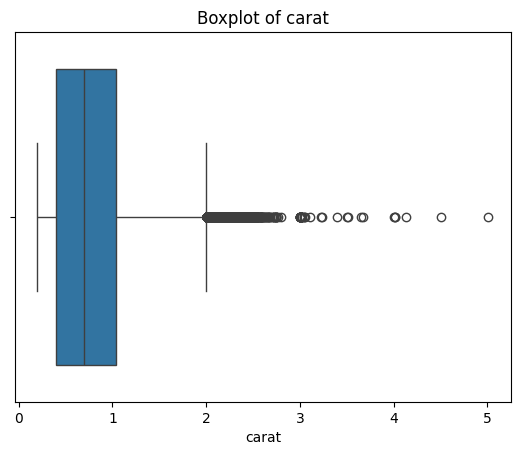

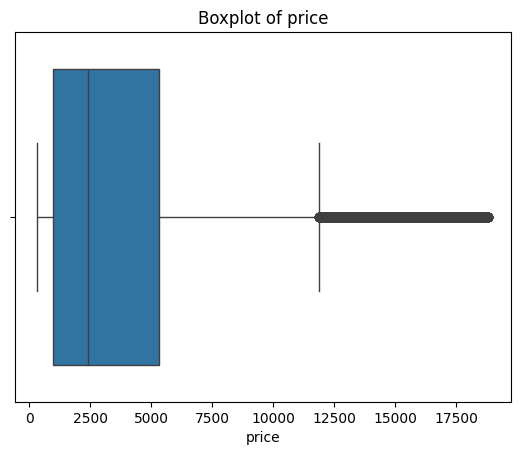

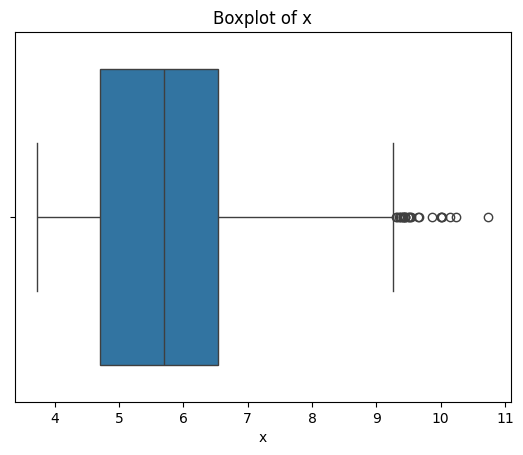

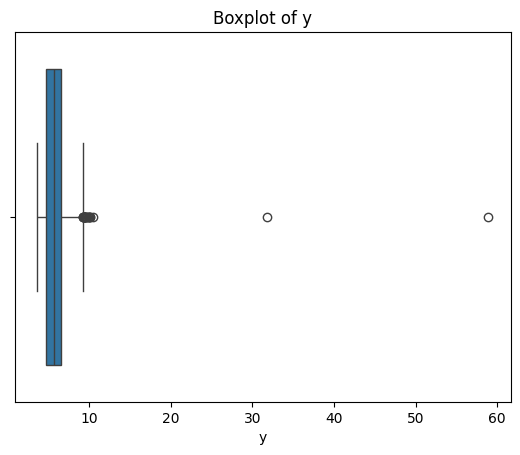

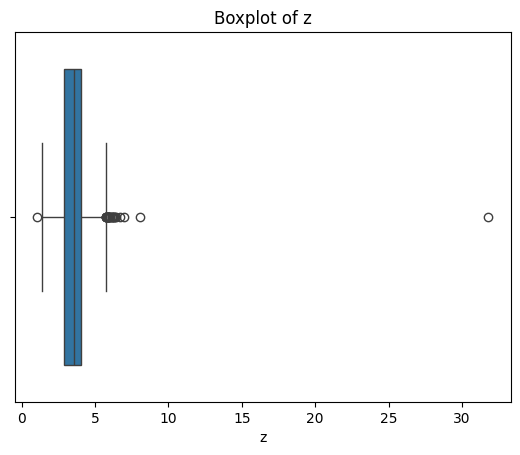

In [ ]:
# Visual check before
for col in numeric_cols:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [ ]:
df = remove_outliers_iqr(df, numeric_cols)
print(df.shape)

(49498, 10)


## Step 4: Skewness Check and Treatment

In [ ]:
print(df[numeric_cols].skew())

carat    0.659295
price    1.126114
x        0.219279
y        0.213771
z        0.220114
dtype: float64


In [ ]:
# Apply log1p transformation to highly skewed features (example)
skewed_cols = ['price', 'carat', 'x', 'y', 'z']
for col in skewed_cols:
    df[f'{col}_log'] = np.log1p(df[col])

In [86]:
# If price skewed, use log1p
import numpy as np
print("price skew:", df['price'].skew())
df['price_log'] = np.log1p(df['price'])
# Use 'price_log' as target when training; remember to inverse-transform preds:
# price_pred = np.expm1(pred_log)


price skew: 1.126113739589299


## Step 5: Exploratory Data Analysis (EDA)

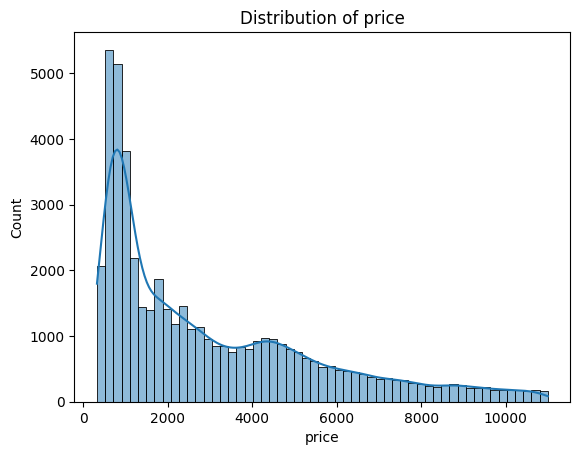

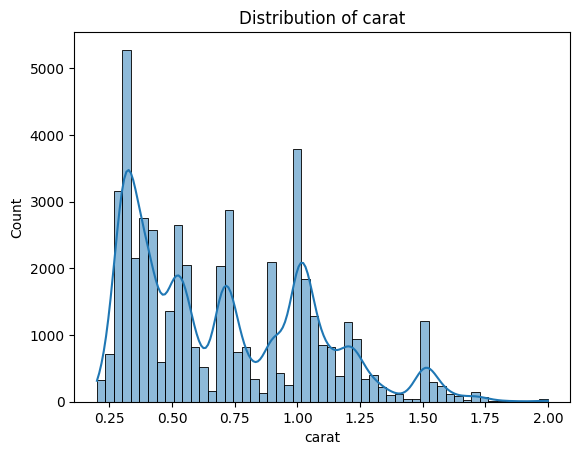

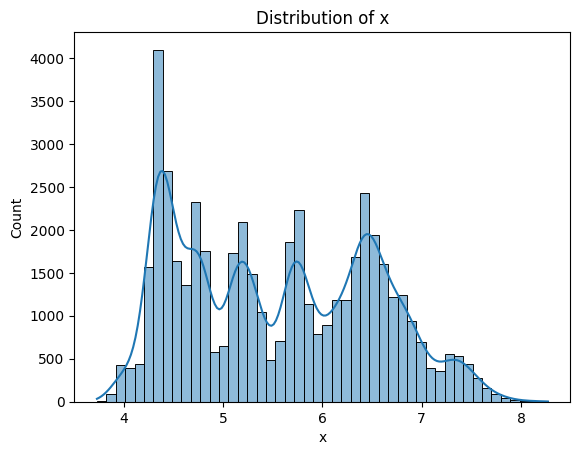

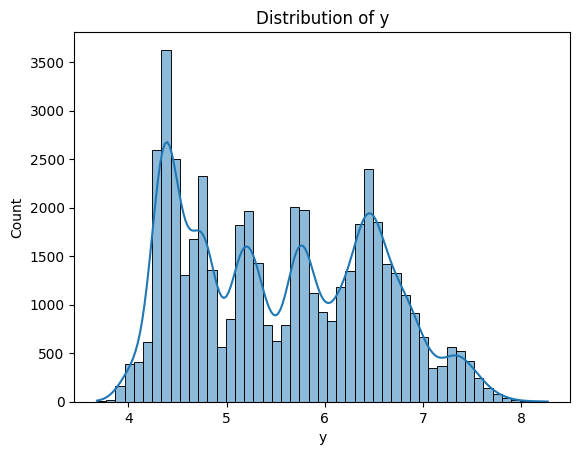

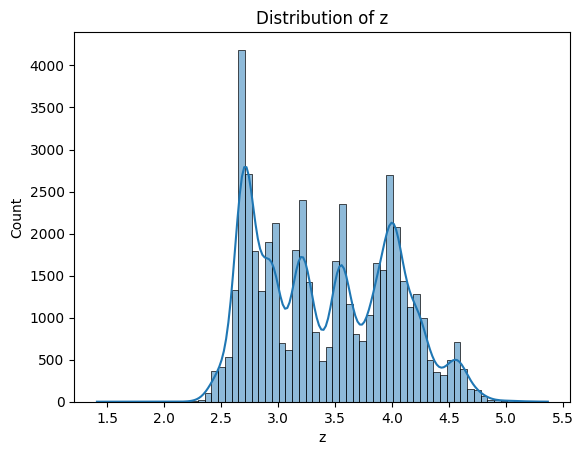

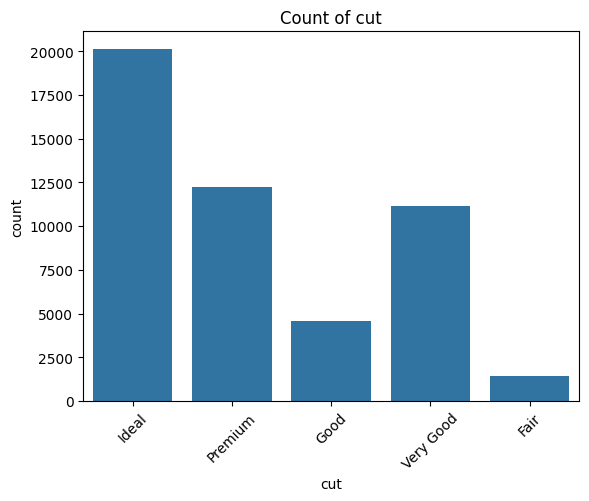

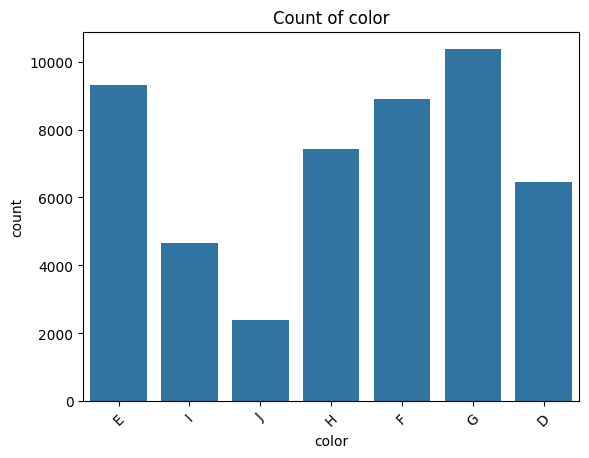

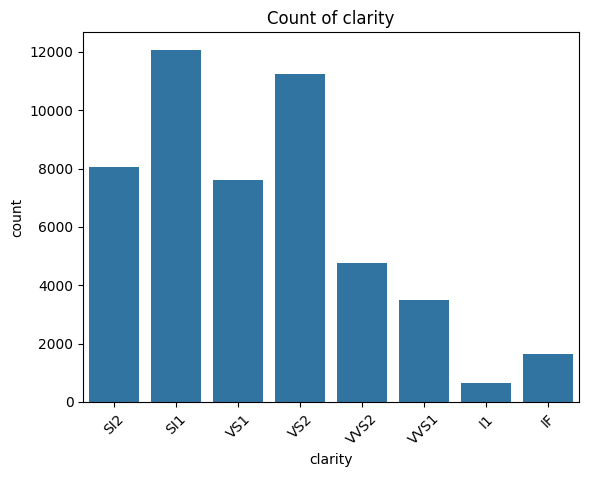

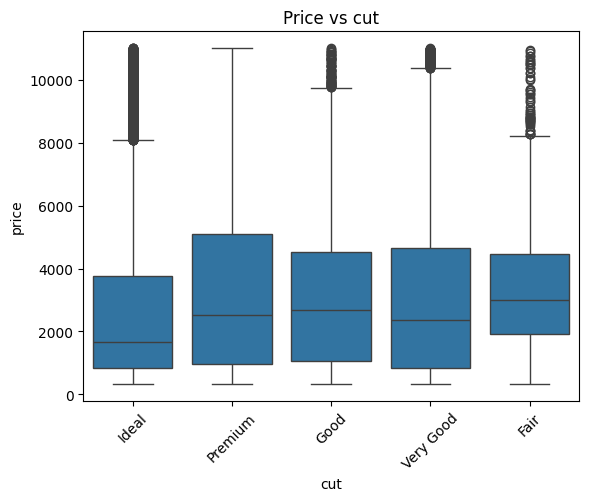

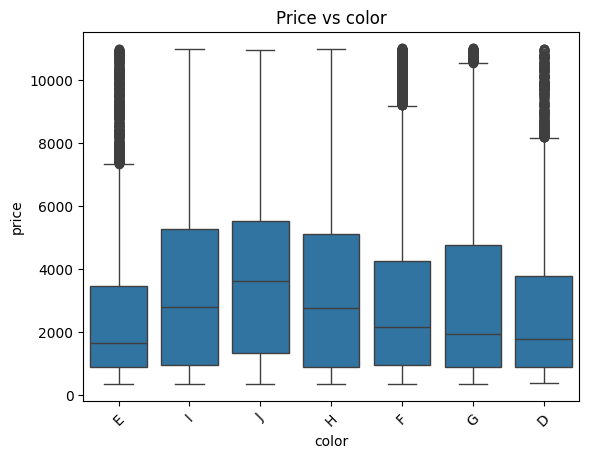

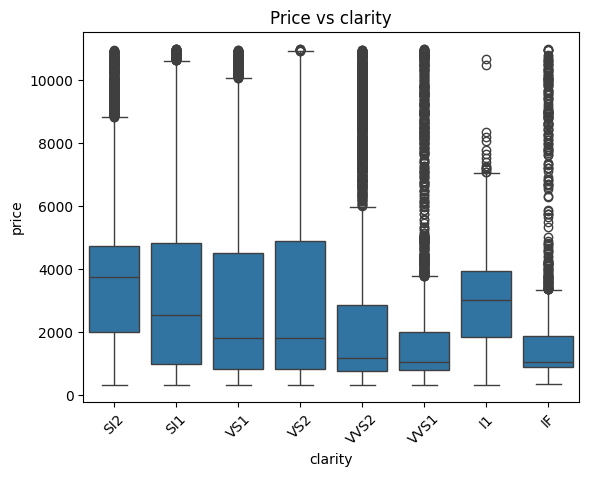

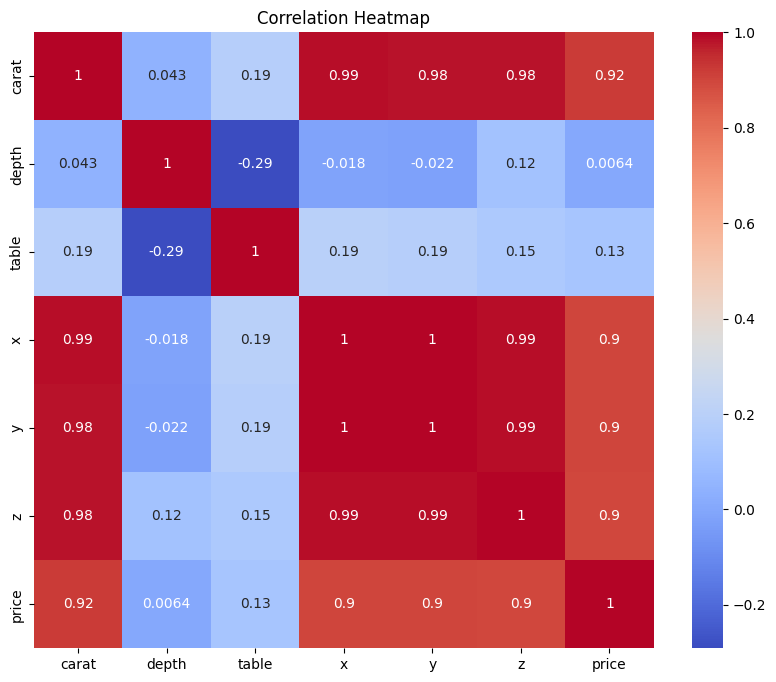

In [ ]:
# Distribution plots
for col in ['price', 'carat', 'x', 'y', 'z']:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Count plots
for col in ['cut', 'color', 'clarity']:
    sns.countplot(x=df[col])
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
    plt.show()

# Boxplots: price vs categorical
for col in ['cut', 'color', 'clarity']:
    sns.boxplot(x=col, y='price', data=df)
    plt.title(f'Price vs {col}')
    plt.xticks(rotation=45)
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[['carat','depth','table','x','y','z','price']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


## Step 6: Feature Engineering

In [ ]:
USD_TO_INR = 80  # choose a fixed rate for project
df['price_inr'] = df['price'] * USD_TO_INR

In [ ]:
# Volume
df['volume'] = df['x'] * df['y'] * df['z']

In [ ]:
# Price per carat
df['price_per_carat'] = df['price'] / df['carat']

In [ ]:
# Dimension ratio
df['dimension_ratio'] = (df['x'] + df['y']) / (2 * df['z'])

In [ ]:
# Carat category
def carat_category(c):
    if c < 0.5:
        return 'Light'
    elif c <= 1.5:
        return 'Medium'
    else:
        return 'Heavy'

In [ ]:
df['carat_category'] = df['carat'].apply(carat_category)
print(df.head())

   carat      cut color clarity  depth  table  price     x     y     z  \
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43   
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31   
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31   
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63   
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75   

   price_log  carat_log     x_log     y_log     z_log  price_inr     volume  \
0   5.789960   0.207014  1.599388  1.605430  1.232560      26080  38.202030   
1   5.789960   0.190620  1.587192  1.576915  1.196948      26080  34.505856   
2   5.793014   0.207014  1.619388  1.623341  1.196948      26160  38.076885   
3   5.814131   0.254642  1.648659  1.654411  1.289233      26720  46.724580   
4   5.817111   0.270027  1.675226  1.677097  1.321756      26800  51.917250   

   price_per_carat  dimension_ratio carat_category  
0      1417.391304         

## Step 7: Feature Selection

In [ ]:
# Candidate features for regression (example)
feature_cols = ['carat', 'depth', 'table', 'x', 'y', 'z',
                'volume', 'price_per_carat', 'dimension_ratio']
cat_cols = ['cut', 'color', 'clarity', 'carat_category']


In [ ]:
X = df[feature_cols + cat_cols]
y = df['price_inr']

In [ ]:
# Basic preprocessing for feature importance
num_features = feature_cols
cat_features = cat_cols

In [ ]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_pipeline = Pipeline(steps=[('preprocess', preprocess),
                             ('model', rf_model)])

rf_pipeline.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z', 'volume',
                                                   'price_per_carat',
                                                   'dimension_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cut', 'color', 'clarity',
                                                   'carat_category'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [ ]:
# Get feature names after encoding
ohe_features = list(rf_pipeline.named_steps['preprocess']
                    .named_transformers_['cat'].get_feature_names_out(cat_features))
all_feature_names = num_features + ohe_features

In [ ]:
importances = rf_pipeline.named_steps['model'].feature_importances_

In [ ]:
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
print(feat_imp.head(20))

y                        0.399560
volume                   0.367871
price_per_carat          0.180310
carat                    0.048829
x                        0.003120
z                        0.000182
dimension_ratio          0.000029
depth                    0.000016
table                    0.000016
carat_category_Medium    0.000014
carat_category_Heavy     0.000007
clarity_SI2              0.000004
clarity_SI1              0.000003
cut_Ideal                0.000003
color_H                  0.000003
carat_category_Light     0.000003
cut_Very Good            0.000003
cut_Premium              0.000002
clarity_IF               0.000002
cut_Fair                 0.000002
dtype: float64


In [92]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_features = ['carat','depth','table','x','y','z']  # numeric
cat_features = ['cut','color','clarity']  # categorical (use onehot or ordinal as appropriate)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
], remainder='drop')
# Fit transform to check:
X = df[num_features + cat_features]
X_trans = preprocessor.fit_transform(X)
print("preprocessor output shape:", X_trans.shape)


preprocessor output shape: (49498, 26)


## Step 8: Encoding Categorical Variables

In [ ]:
num_features = ['carat', 'depth', 'table', 'x', 'y', 'z',
                'volume', 'price_per_carat', 'dimension_ratio']
cat_features = ['cut', 'color', 'clarity', 'carat_category']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

In [90]:
ord_enc = OrdinalEncoder(categories=[['Fair','Good','Very Good','Premium','Ideal']])
df['cut_ord'] = ord_enc.fit_transform(df[['cut']])

color_order = ['J','I','H','G','F','E','D']  # worst->best (flip if needed)
color_enc = OrdinalEncoder(categories=[color_order])
df['color_ord'] = color_enc.fit_transform(df[['color']])

clarity_order = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']
clarity_enc = OrdinalEncoder(categories=[clarity_order])
df['clarity_ord'] = clarity_enc.fit_transform(df[['clarity']])


In [91]:
df[['cut','cut_ord']].drop_duplicates().sort_values('cut_ord')


,cut,cut_ord
8,Fair,0.0
2,Good,1.0
5,Very Good,2.0
1,Premium,3.0
0,Ideal,4.0


## Step 9: Regression Models (Price Prediction)

In [ ]:
X = df[num_features + cat_features]
y = df['price_inr']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

In [ ]:
results = []

In [ ]:
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess),
                          ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

              model           MAE           MSE          RMSE        R2
0  LinearRegression  15713.363306  4.816664e+08  21946.900189  0.988578
1      RandomForest    938.784970  1.097401e+07   3312.704001  0.999740
2           XGBoost   1894.593506  1.478580e+07   3845.231462  0.999649
3      DecisionTree   1676.735354  2.817878e+07   5308.368967  0.999332
4               KNN  15030.574545  6.260755e+08  25021.501482  0.985154


## Step 10: ANN Regression Model

In [78]:
!pip install tensorflow --upgrade --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.


In [93]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Fit preprocess on train and transform train/test
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc = preprocess.transform(X_test)

input_dim = X_train_proc.shape[1]

ann_model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # regression output
])

ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = ann_model.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=256,
    verbose=1
)

# Evaluate
y_pred_ann = ann_model.predict(X_test_proc).flatten()
mae_ann = mean_absolute_error(y_test, y_pred_ann)
mse_ann = mean_squared_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test, y_pred_ann)

print("ANN -> MAE:", mae_ann, "MSE:", mse_ann, "RMSE:", rmse_ann, "R2:", r2_ann)


Epoch 1/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 99531481088.0000 - mae: 239911.4531 - val_loss: 100260929536.0000 - val_mae: 240122.8906
Epoch 2/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 102837239808.0000 - mae: 244561.3750 - val_loss: 98901532672.0000 - val_mae: 238427.9688
Epoch 3/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 100366639104.0000 - mae: 241332.3438 - val_loss: 94682365952.0000 - val_mae: 233302.8125
Epoch 4/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 93839335424.0000 - mae: 232800.2188 - val_loss: 86488293376.0000 - val_mae: 223149.3281
Epoch 5/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 84272070656.0000 - mae: 221337.5625 - val_loss: 74317643776.0000 - val_mae: 207170.0312
Epoch 6/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 70634815488.0000 - mae: 202501.5000 - val_loss: 59085295616.0000 - val_mae: 185104.8906
Epoch 7/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 55543541760.0000 - mae: 180162.7656 - val_los

## Step 11: Save Best Regression Model

In [ ]:
best_regression_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(n_estimators=300, random_state=42))
])

best_regression_pipeline.fit(X, y)

joblib.dump(best_regression_pipeline, 'best_regression_model.pkl')
# For ANN you would save preprocess + ANN separately if ANN is best.


['best_regression_model.pkl']

## Step 12: Clustering for Market Segmentation

In [ ]:
# Features for clustering: drop price/price_inr
cluster_features = num_features + cat_features
X_cluster = df[cluster_features]

X_cluster_proc = preprocess.fit_transform(X_cluster)

inertias = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster_proc)
    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_cluster_proc, labels)
    sil_scores.append(sil)
    print(f'k={k}, inertia={kmeans.inertia_}, silhouette={sil}')

# Choose best k based on elbow + silhouette (e.g., k=4)
best_k = 4
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_proc)

df['cluster'] = cluster_labels
joblib.dump(kmeans_final, 'best_kmeans_model.pkl')
joblib.dump(preprocess, 'cluster_preprocess.pkl')


k=2, inertia=363255.95496604993, silhouette=0.33070406393887564
k=3, inertia=316149.3068516365, silhouette=0.21677278311648424
k=4, inertia=285463.6849894413, silhouette=0.21243221402261928
k=5, inertia=267532.65546712675, silhouette=0.1892208533765402
k=6, inertia=251105.17646376885, silhouette=0.17773644360092936
k=7, inertia=239294.30275807442, silhouette=0.1762005712729241
k=8, inertia=231020.83546586448, silhouette=0.15728496054605148
k=9, inertia=223291.63273131903, silhouette=0.15803098175451372


['cluster_preprocess.pkl']

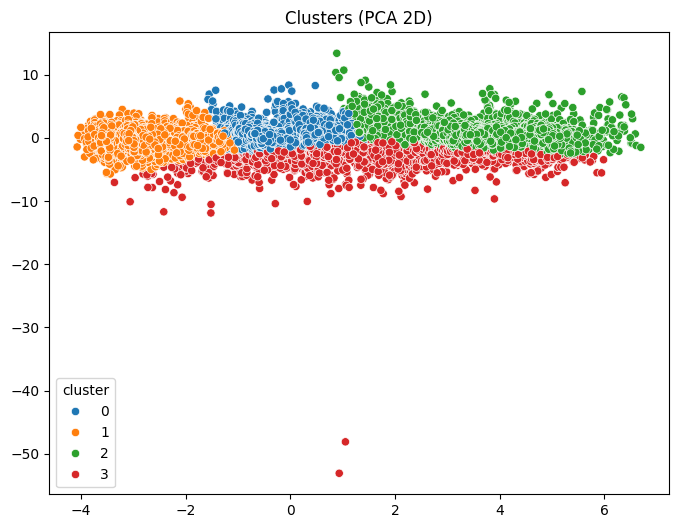

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster_proc)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=df['cluster'], palette='tab10')
plt.title('Clusters (PCA 2D)')
plt.show()


## Step 13: Cluster Analysis and Naming

In [ ]:
cluster_summary = df.groupby('cluster').agg({
    'price_inr': 'mean',
    'carat': 'mean'
}).rename(columns={'price_inr': 'avg_price_inr', 'carat': 'avg_carat'})

print(cluster_summary)

cut_dist = df.groupby('cluster')['cut'].value_counts(normalize=True)
print(cut_dist)

# Manual mapping based on analysis
cluster_name_map = {
    0: 'Premium Heavy Diamonds',
    1: 'Affordable Small Diamonds',
    2: 'Mid-range Balanced Diamonds',
    3: 'Other Segment'
}

df['cluster_name'] = df['cluster'].map(cluster_name_map)


         avg_price_inr  avg_carat
cluster                          
0        176608.755985   0.633949
1         63216.431053   0.344027
2        492707.532616   1.150836
3        325346.282621   0.915071
cluster  cut      
0        Ideal        0.501923
         Very Good    0.226356
         Premium      0.171572
         Good         0.072051
         Fair         0.028098
1        Ideal        0.498946
         Premium      0.228912
         Very Good    0.201743
         Good         0.065786
         Fair         0.004614
2        Ideal        0.332145
         Premium      0.271975
         Very Good    0.235973
         Good         0.108933
         Fair         0.050973
3        Premium      0.425865
         Very Good    0.271796
         Good         0.187512
         Ideal        0.058960
         Fair         0.055867
Name: proportion, dtype: float64


## Step 14: Streamlit App – Structure

In [ ]:
!pip install -q streamlit

# download cloudflared binary
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O cloudflared
!chmod +x cloudflared


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.9 MB/s eta 0:00:00
--2025-12-06 13:15:14--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64 [following]
--2025-12-06 13:15:14--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/955e9d1b-ac5e-4188-8867-e5f53958a8fe?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-06T14%3A13%3A57Z&rscd=attachment%3B+filename%3Dcl

In [ ]:
%%bash
pip install -q streamlit

wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O /content/cloudflared
chmod +x /content/cloudflared


In [ ]:
import pickle, numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

X = np.random.rand(30, 12)
y = np.random.rand(30)

reg = DummyRegressor().fit(X, y)
clust = KMeans(n_clusters=3, random_state=42).fit(X)
scaler = StandardScaler().fit(X)

enc = {
    "cut": OrdinalEncoder().fit([["Fair"], ["Good"], ["Very Good"], ["Premium"], ["Ideal"]]),
    "color": OrdinalEncoder().fit([["D"], ["E"], ["F"], ["G"], ["H"], ["I"], ["J"]]),
    "clarity": OrdinalEncoder().fit([["IF"],["VVS1"],["VVS2"],["VS1"],["VS2"],["SI1"],["SI2"],["I1"]]),
    "carat_category": OrdinalEncoder().fit([["Light"], ["Medium"], ["Heavy"]])
}

cluster_names = {
    0: "Premium Heavy Diamonds",
    1: "Affordable Small Diamonds",
    2: "Mid-range Balanced Diamonds",
}

pickle.dump(reg, open("/content/regression_model.pkl", "wb"))
pickle.dump(clust, open("/content/clustering_model.pkl", "wb"))
pickle.dump(scaler, open("/content/scaler.pkl", "wb"))
pickle.dump(enc, open("/content/encoders.pkl", "wb"))
pickle.dump(cluster_names, open("/content/cluster_names.pkl", "wb"))

print("ALL MODEL FILES CREATED SUCCESSFULLY.")


ALL MODEL FILES CREATED SUCCESSFULLY.


In [96]:
%%writefile /content/app.py
import streamlit as st
import numpy as np
import pandas as pd
import pickle
import os

# -----------------------------
# Load Saved Artifacts
# -----------------------------
def load_file(path):
    with open(path, "rb") as f:
        return pickle.load(f)

reg_model = load_file("/content/regression_model.pkl")
clust_model = load_file("/content/clustering_model.pkl")
scaler = load_file("/content/scaler.pkl")
encoders = load_file("/content/encoders.pkl")
cluster_names = load_file("/content/cluster_names.pkl")

# -----------------------------
# Streamlit Setup
# -----------------------------
st.set_page_config(page_title="Diamond Dynamics", layout="wide")
st.title("💎 Diamond Dynamics: Price Prediction & Market Segmentation")

tab_price, tab_cluster, tab_info = st.tabs(
    ["💰 Price Prediction", "📊 Market Segment", "ℹ️ Info"]
)

# -----------------------------
# Input Form (Unique Keys)
# -----------------------------
def diamond_form(prefix=""):
    col1, col2, col3 = st.columns(3)

    with col1:
        carat = st.number_input("Carat", 0.1, 5.0, 0.7, 0.01, key=f"carat_{prefix}")
        x = st.number_input("Length (x)", 0.1, 15.0, 5.5, 0.1, key=f"x_{prefix}")
        y = st.number_input("Width (y)", 0.1, 15.0, 5.6, 0.1, key=f"y_{prefix}")

    with col2:
        z = st.number_input("Depth (z)", 0.1, 15.0, 3.5, 0.1, key=f"z_{prefix}")
        depth = st.number_input("Depth %", 40.0, 80.0, 61.0, 0.1, key=f"depth_{prefix}")
        table = st.number_input("Table %", 40.0, 80.0, 57.0, 0.1, key=f"table_{prefix}")

    with col3:
        cut = st.selectbox("Cut", ["Fair","Good","Very Good","Premium","Ideal"], key=f"cut_{prefix}")
        color = st.selectbox("Color", ["D","E","F","G","H","I","J"], key=f"color_{prefix}")
        clarity = st.selectbox("Clarity", ["IF","VVS1","VVS2","VS1","VS2","SI1","SI2","I1"], key=f"clarity_{prefix}")

    return {
        "carat":carat, "depth":depth, "table":table, "x":x, "y":y, "z":z,
        "cut":cut, "color":color, "clarity":clarity
    }

# -----------------------------
# Build Feature Vector
# -----------------------------
def build_features(data):
    df = pd.DataFrame([data])
    df["volume"] = df["x"] * df["y"] * df["z"]
    df["dimension_ratio"] = (df["x"] + df["y"]) / (2 * df["z"])
    df["carat_category"] = pd.cut(df["carat"], [0,0.5,1.5,10], labels=["Light","Medium","Heavy"])

    for col in ["cut", "color", "clarity", "carat_category"]:
        df[col] = encoders[col].transform(df[[col]])

    cols = [
        "carat","depth","table","x","y","z","cut","color","clarity",
        "volume","dimension_ratio","carat_category"
    ]

    X = df[cols].astype(float).values
    return scaler.transform(X)

# -----------------------------
# Price Prediction
# -----------------------------
with tab_price:
    st.subheader("Price Prediction (INR)")
    inputs = diamond_form("p")

    if st.button("Predict Price", key="pp"):
        X = build_features(inputs)
        pred_usd = reg_model.predict(X)[0]
        pred_inr = pred_usd * 83
        st.success(f"Predicted Price: ₹{pred_inr:,.2f}")

# -----------------------------
# Clustering
# -----------------------------
with tab_cluster:
    st.subheader("Market Segment")
    inputs2 = diamond_form("c")

    if st.button("Predict Segment", key="cs"):
        X2 = build_features(inputs2)
        label = int(clust_model.predict(X2)[0])
        st.success(f"Market Segment: {cluster_names[label]}")

# -----------------------------
# Info Tab
# -----------------------------
with tab_info:
    st.markdown(
        """
        ### 📘 Project Overview
        **Diamond Dynamics** predicts diamond prices using regression
        and classifies diamonds into 3 major **market segments** using clustering.

        This app demonstrates:
        - Data preprocessing
        - Feature engineering
        - Price prediction
        - Market segmentation
        - Streamlit UI
        """
    )


Overwriting /content/app.py


In [97]:
%%bash
nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 > /content/log.txt 2>&1 &
sleep 5
nohup /content/cloudflared tunnel --url http://localhost:8501 > /content/cf.log 2>&1 &
sleep 5
grep -o 'https://.*\.trycloudflare.com' /content/cf.log | head -n 1


https://www-albums-forgot-nottingham.trycloudflare.com
